In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('TSLA.csv'  , index_col='Date', parse_dates=True , dayfirst=True , usecols=['Date','Close'])  

In [3]:
data

,Close
Date,
2019-05-21,41.015999
2019-05-22,38.546001
2019-05-23,39.098000
2019-05-24,38.125999
2019-05-28,37.740002
...,...
2022-05-16,724.369995
2022-05-17,761.609985
2022-05-18,709.809998


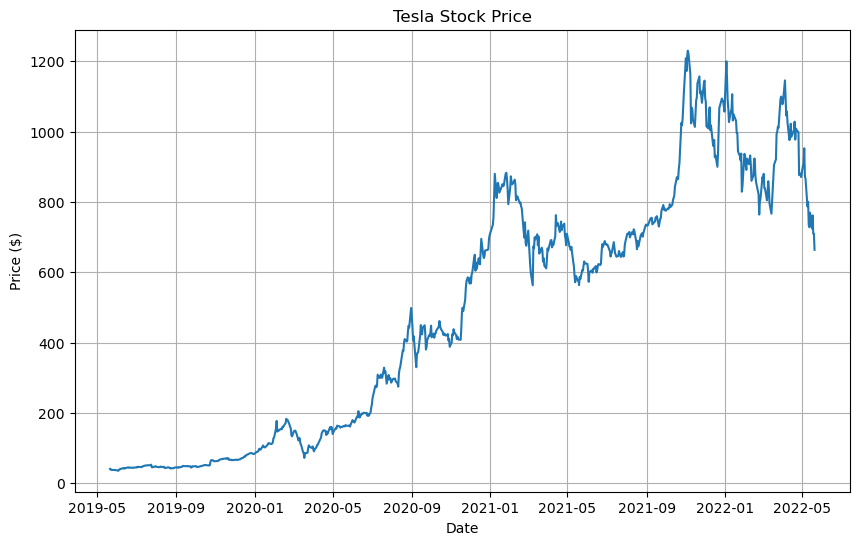

In [4]:
plt.figure(figsize=(10,6))
plt.plot(data) 
plt.title('Tesla Stock Price')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.grid(True)
plt.show()


In [5]:
roll_mean = data.rolling(7).mean() # moving average
roll_std = data.rolling(7).std() # moving standard deviation


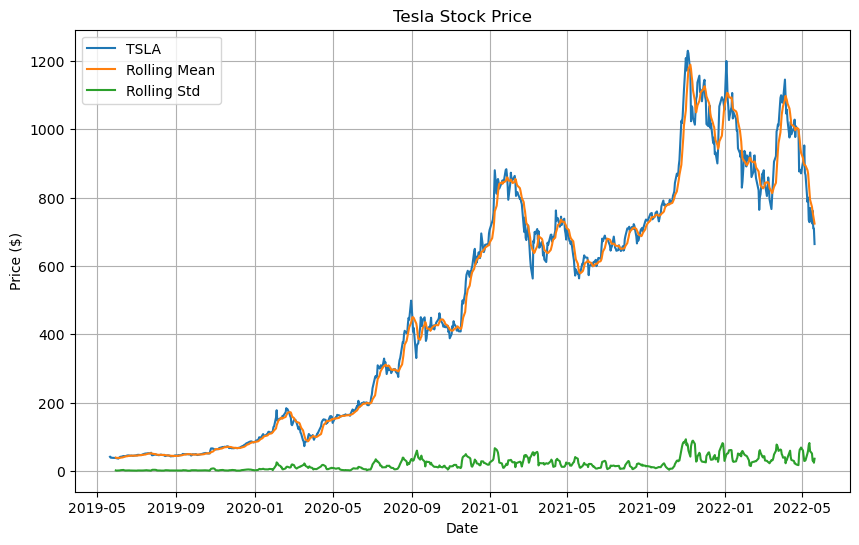

In [6]:
plt.figure(figsize=(10,6))
plt.plot(data, label='TSLA')
plt.plot(roll_mean, label='Rolling Mean')
plt.plot(roll_std, label='Rolling Std')
plt.legend(loc='best')
plt.title('Tesla Stock Price')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.grid(True)
plt.show()


In [7]:
# check weather the data is stationary or not
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] > 0.05:
    print('The data is not stationary')
else:
    print('The data is stationary')


ADF Statistic: -1.363009
p-value: 0.599876
The data is not stationary


In [8]:
data_diff = data.diff().dropna() # differencing the data to make it stationary

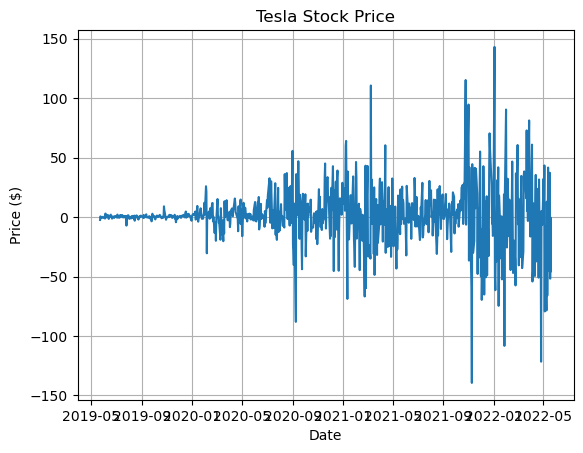

In [9]:
plt.plot(data_diff)
plt.title('Tesla Stock Price')
plt.ylabel('Price ($)')
plt.xlabel('Date')  
plt.grid(True)
plt.show()

In [10]:
# lets check again ada fuller test
result = adfuller(data_diff['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] > 0.05:
    print('The data is not stationary')
else:
    print('The data is stationary')

ADF Statistic: -8.324564
p-value: 0.000000
The data is stationary


#### as we are going to use ARIMA model, we need to find the values of p,d,q
#### p is the order of the AR term
#### q is the order of the MA term
#### d is the number of differencing required to make the data stationary
#### using acf we can find the value of q
#### using pacf we can find the value of p
#### acf is the plot between the data and its lagged value
#### pacf is the plot between the data and its lagged value after removing the effect of the intermediate lagged values

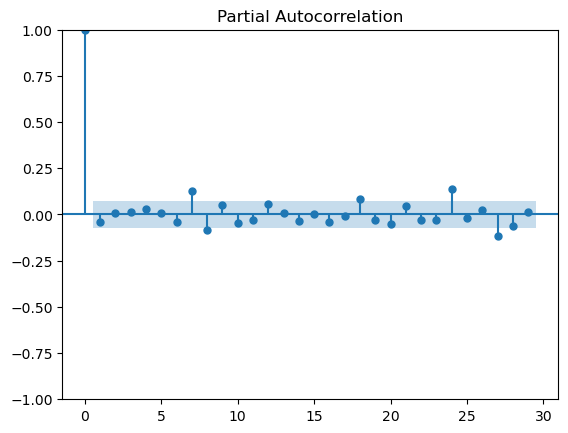

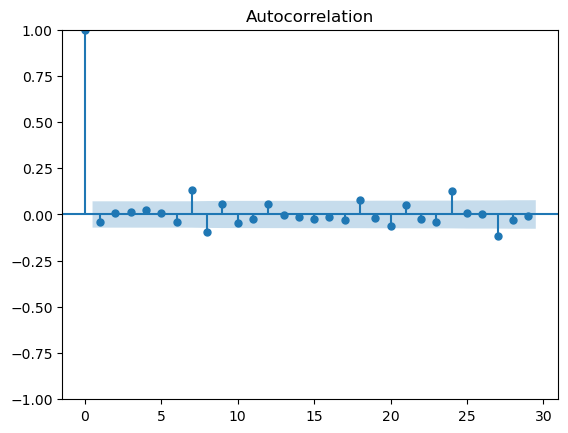

In [11]:


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(data_diff)  # here lags us the number of values to be considered for finding the value of p 
plot_acf(data_diff)   # here lags us the number of values to be considered for finding the value of q
plt.show()


In [13]:
# lets split the data into train and test
train_data = data.Close[0:-60]
test_data = data.Close[-60:]

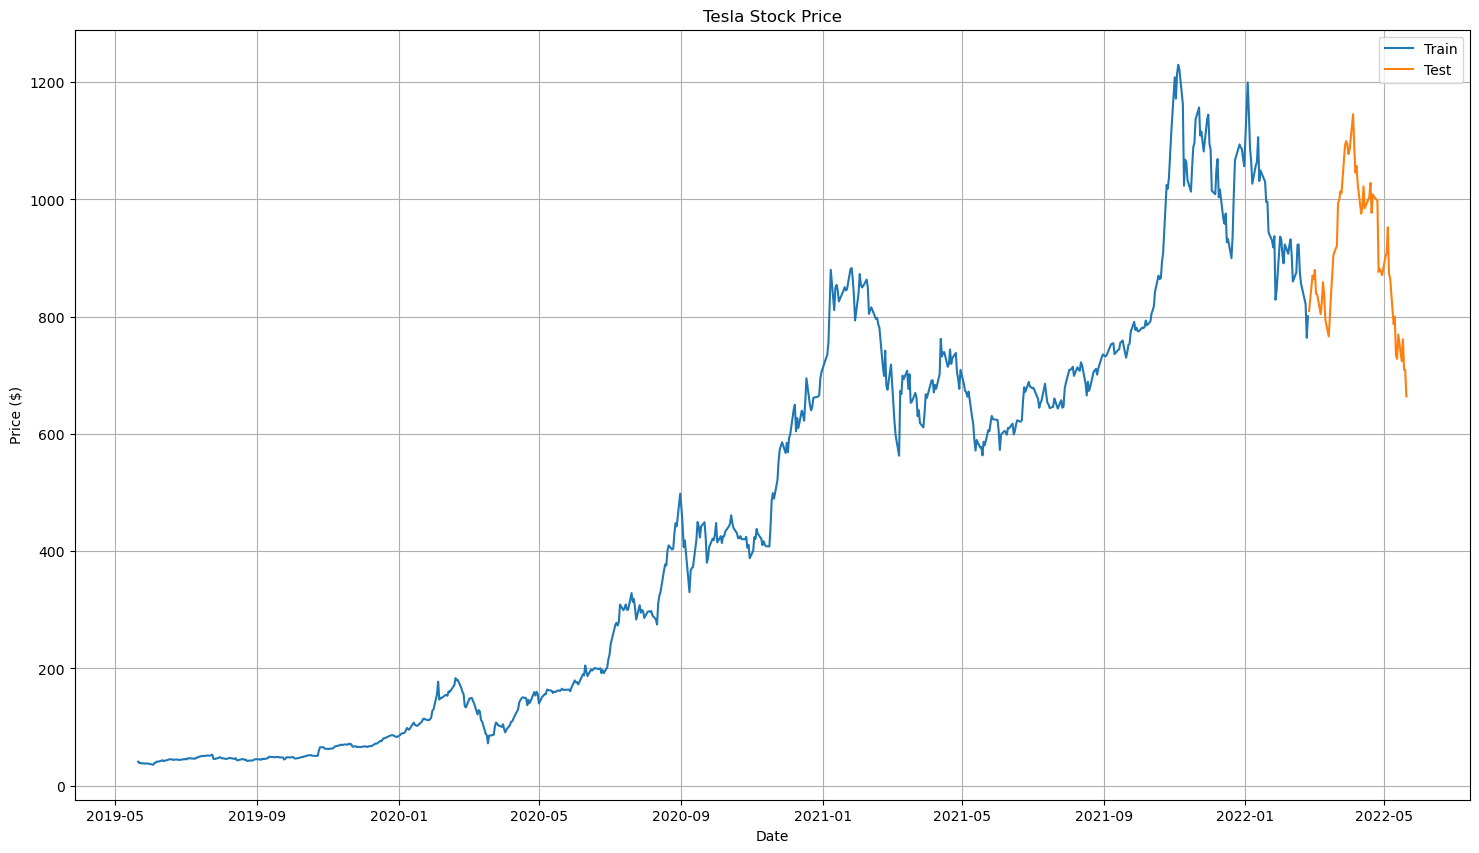

In [14]:
plt.figure(figsize=(18,10))
plt.plot(train_data)
plt.plot(test_data)
plt.title('Tesla Stock Price')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.legend(['Train', 'Test'], loc='best')
plt.grid(True)

In [18]:
history = [x for x in train_data]

In [19]:
history

[41.01599884033203,
 38.54600143432617,
 39.09799957275391,
 38.1259994506836,
 37.7400016784668,
 37.97200012207031,
 37.64400100708008,
 37.03200149536133,
 35.79399871826172,
 38.720001220703125,
 39.31800079345703,
 41.18999862670898,
 40.900001525878906,
 42.57600021362305,
 43.41999816894531,
 41.85200119018555,
 42.78200149536133,
 42.98400115966797,
 45.00600051879883,
 44.948001861572266,
 45.2859992980957,
 43.92399978637695,
 44.37200164794922,
 44.72800064086914,
 43.95199966430664,
 43.854000091552734,
 44.56800079345703,
 44.69200134277344,
 45.43399810791016,
 44.90999984741211,
 46.97999954223633,
 46.619998931884766,
 46.06800079345703,
 46.012001037597656,
 47.78400039672852,
 47.720001220703125,
 49.01599884033203,
 50.70000076293945,
 50.47600173950195,
 50.97200012207031,
 50.70800018310547,
 51.63600158691406,
 51.13600158691406,
 52.03400039672852,
 52.97600173950195,
 45.76399993896485,
 45.608001708984375,
 47.15399932861328,
 48.45199966430664,
 48.32199859619

In [20]:
# lets build the model
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(history, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  698
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3150.350
Date:                Fri, 08 Sep 2023   AIC                           6306.700
Time:                        15:25:49   BIC                           6320.340
Sample:                             0   HQIC                          6311.974
                                - 698                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2397      0.699      0.343      0.731      -1.129       1.609
ma.L1         -0.2713      0.690     -0.393      0.694      -1.623       1.080
sigma2       493.6767     11.690     42.231      0.0

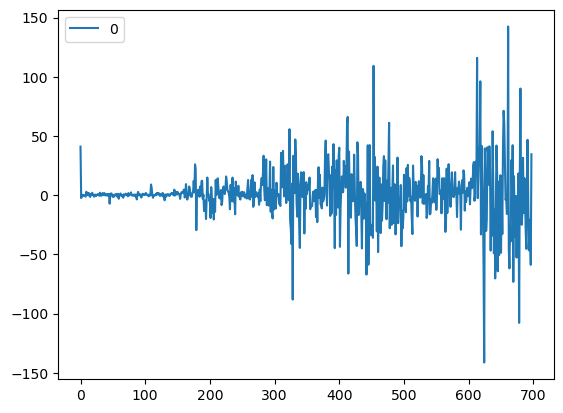

In [21]:

# check the residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error

history  = [x for x in train_data]
predictions = []
for i in range(len(test_data)):
    model = ARIMA(history , order=(2,0,0))
    model_fit = model.fit()
    fc = model_fit.forecast(alpha = 0.05)[0]   # 95% confidence interval
    predictions.append(fc)
    history.append(test_data[i])
print(f"RMSE is {np.sqrt(mean_squared_error(test_data , predictions))}")

c:\Users\Gaurang\anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


RMSE is 39.439956568889265


In [24]:
predictions = pd.Series(predictions , index=test_data.index)

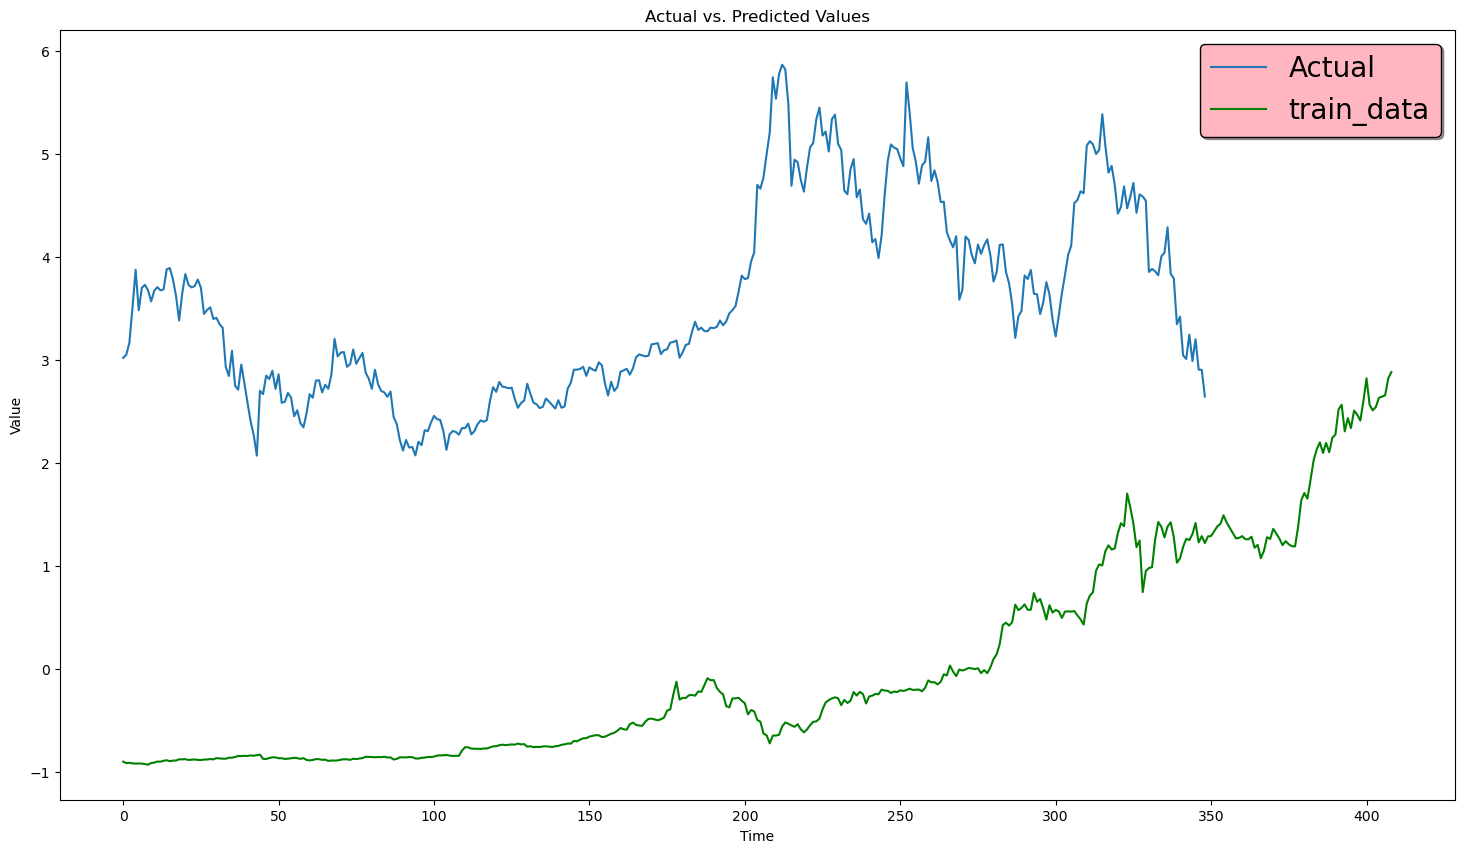

In [266]:
# Predict using the trained model on the test data
# Plot the actual vs. predicted values
plt.figure(figsize=(18, 10))
plt.plot(test_data, label='Actual')
plt.plot(train_data , label = "train_data" ,color = "green")
plt.legend(loc='best', fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Data Preprocessing

Now consider the time steps, if I want to predict the close price in a day that how previous data should be considered.

For example: 

Let's take the timestep value 10. Let’s split the data into X, Y. In the 0th iteration, the first 10 elements goes as your first record and stored in X and the 11th elements will be put up in the y as output of that 10 records. Next, in the 1th iteration, from 1 to 11 elements are stored as record in X and 12th element in y as output. These records are nothing but feature values or input that is used to train our model and the output will be target value that model will predict.

This process of creating features and target variable is also known as **Data Windowing**

| X | y |
| --- | --- |
| 67, 34, 23, 42, 23, 45, 69, 12, 34, 25 | **27** |
| 34, 23, 42, 23, 45, 69, 12, 34, 25, **27** | **31** |
| 23, 42, 23, 45, 69, 12, 34, 25, 27, **31** | **33** |
| 42, 23, 45, 69, 12, 34, 25, 27, 31, **33** | **29** | 
| 23, 45, 69, 12, 34, 25, 27, 31, 33, **29** | **32** |
| 45, 69, 12, 34, 25, 27, 31, 33, 29, **32** | **34** |
| 69, 12, 34, 25, 27, 31, 33, 29, 32, **34** | **28** |



Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, horizon and window.

horizon = number of timesteps to predict into future....
window = number of timesteps from past used to predict horizon...

In [471]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load your data and select the 'Close' column
data = data[["Close"]]

# Create copies of the original data frames for training and testing
train_data = data[data.index < '2021'].copy()
test_data = data[data.index > '2021'].copy()

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform 'Close' in the training data
train_data['Close'] = scaler.fit_transform(train_data[['Close']])

# Transform 'Close' in the test data using the same scaler
test_data['Close'] = scaler.transform(test_data[['Close']])

def make_windows(data, window_size: int, horizon: int):
    """
    This function converts the data into windows data.
    
    Args:
        data (ndarray): The train or test data.
        window_size (int): Feature window size.
        horizon (int): How many days to predict based on the data.

    Returns:
        tuple: A tuple containing four items: (X_train, y_train, X_train_index, y_train_index).
    """
    
    X_train = []
    y_train = []
    X_train_index = []  # Store index values for X_train
    y_train_index = []  # Store index values for y_train

    for i in range(window_size, len(data) - horizon):
        X_window = data.iloc[i - window_size: i]
        y_window = data.iloc[i: i + horizon, -1]
        
        X_train.append(X_window)
        y_train.append(y_window)
        
        # Store the corresponding index values
        X_train_index.append(X_window.index)
        y_train_index.append(y_window.index)

    X_train = np.array(X_train)
    y_train = np.array(y_train).reshape(-1, 1)

    return X_train, y_train, X_train_index, y_train_index

# Create windows for training and testing
window_size = 60
horizon = 1
X_train, y_train, X_train_index, y_train_index = make_windows(train_data, window_size, horizon)
X_test, y_test, X_test_index, y_test_index = make_windows(test_data, window_size, horizon)

# Print the shapes of the generated data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

warnings.filterwarnings('ignore')
tf.random.set_seed(1234)

# Build and compile the GRU model
model_1 = Sequential()
model_1.add(GRU(units=256, input_shape=(X_train.shape[1], X_train.shape[2])))
model_1.add(Dense(units=10, activation="relu"))
model_1.add(Dense(units=1))
adamopt = Adam(lr=0.001)
model_1.compile(optimizer=adamopt, loss='mse')

# Define early stopping criteria
earlystop = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=5,
    restore_best_weights=True
)

# Train the model
model_1_history = model_1.fit(X_train, y_train, epochs=100, callbacks=[earlystop], validation_data=(X_test, y_test))



X_train shape: (348, 60, 1)
y_train shape: (348, 1)
X_test shape: (288, 60, 1)
y_test shape: (288, 1)
Epoch 1/100
11/11 [==============================] - 6s 118ms/step - loss: 0.2563 - val_loss: 0.0878
Epoch 2/100
11/11 [==============================] - 1s 48ms/step - loss: 0.0293 - val_loss: 0.0843
Epoch 3/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0154 - val_loss: 0.1111
Epoch 4/100
11/11 [==============================] - 0s 41ms/step - loss: 0.0121 - val_loss: 0.0706
Epoch 5/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0104 - val_loss: 0.0975
Epoch 6/100
11/11 [==============================] - 0s 37ms/step - loss: 0.0099 - val_loss: 0.0636
Epoch 7/100
11/11 [==============================] - 0s 38ms/step - loss: 0.0098 - val_loss: 0.0455
Epoch 8/100
11/11 [==============================] - 0s 39ms/step - loss: 0.0093 - val_loss: 0.0898
Epoch 9/100
11/11 [==============================] - 0s 36ms/step - loss: 0.0089 - val_loss: 0.04

9/9 [==============================] - 1s 12ms/step
RMSE : 32.62345599157428


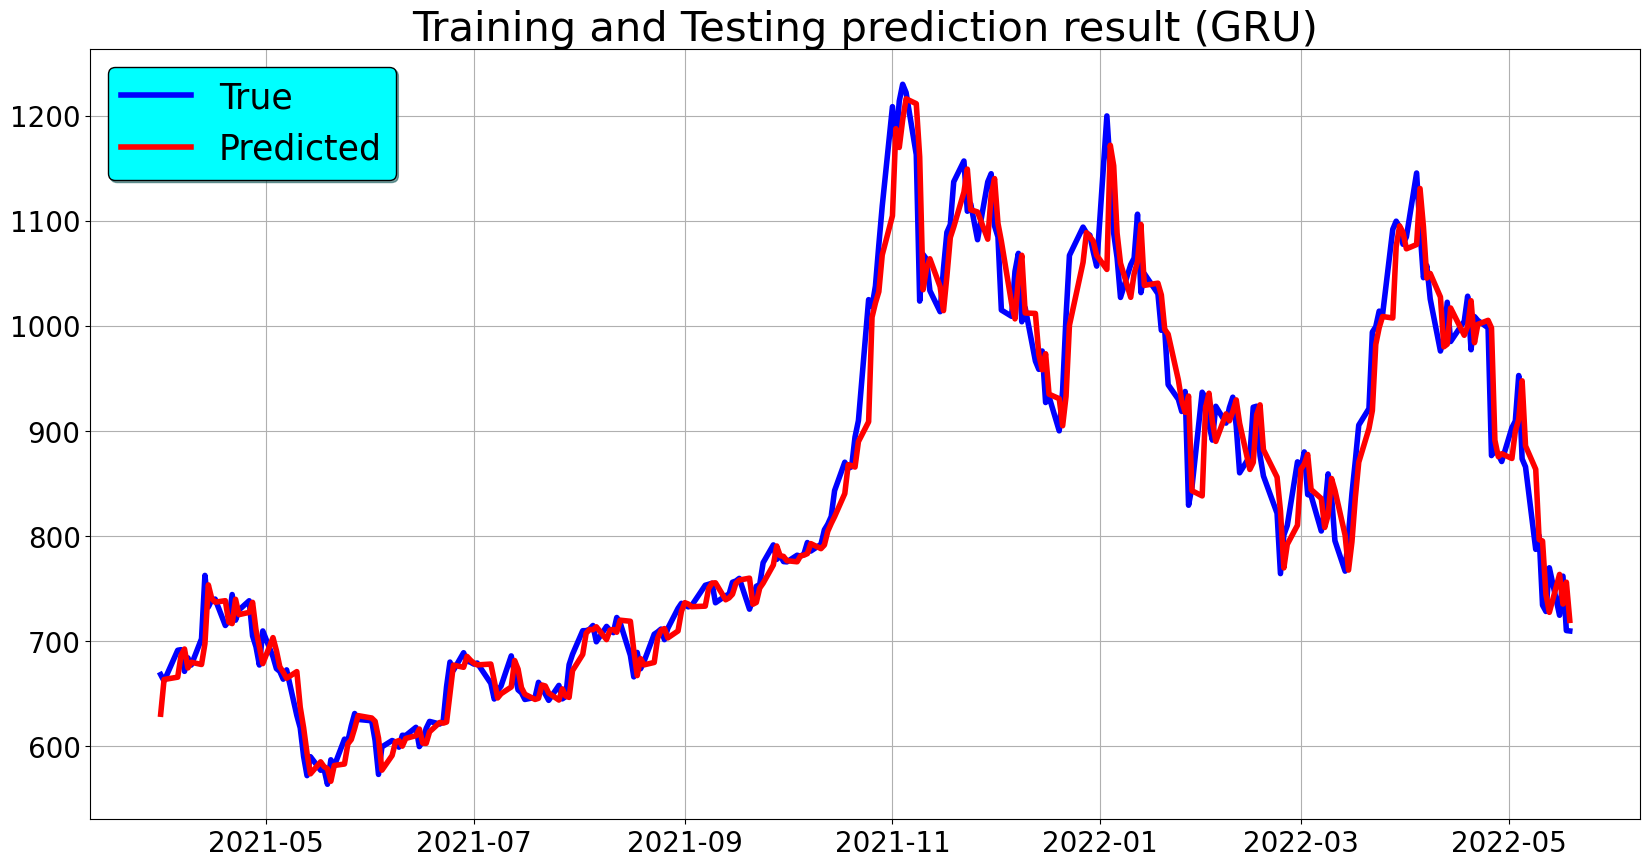

In [472]:
# Evaluate the model on the test data
model_1.evaluate(X_test, y_test)
test_predict_1 = model_1.predict(X_test)
test_predict_1 = scaler.inverse_transform(test_predict_1)
y_test = scaler.inverse_transform(y_test)

print('RMSE :', np.sqrt(mean_squared_error(y_test, test_predict_1)))

# Plot the results with proper indexing
plt.figure(figsize=(20, 10))
plt.grid(b=True, which='major', axis='both')
plt.title('Training and Testing prediction result (GRU)', fontsize=30)
plt.plot(y_test_index, y_test, linewidth=4, label='True', color='blue')  # Plot testing data
plt.plot(y_test_index, test_predict_1, linewidth=4, color='red', label='Predicted')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=25, shadow=True, facecolor='cyan', edgecolor='k')
plt.show()


1/1 [==============================] - 0s 34ms/step


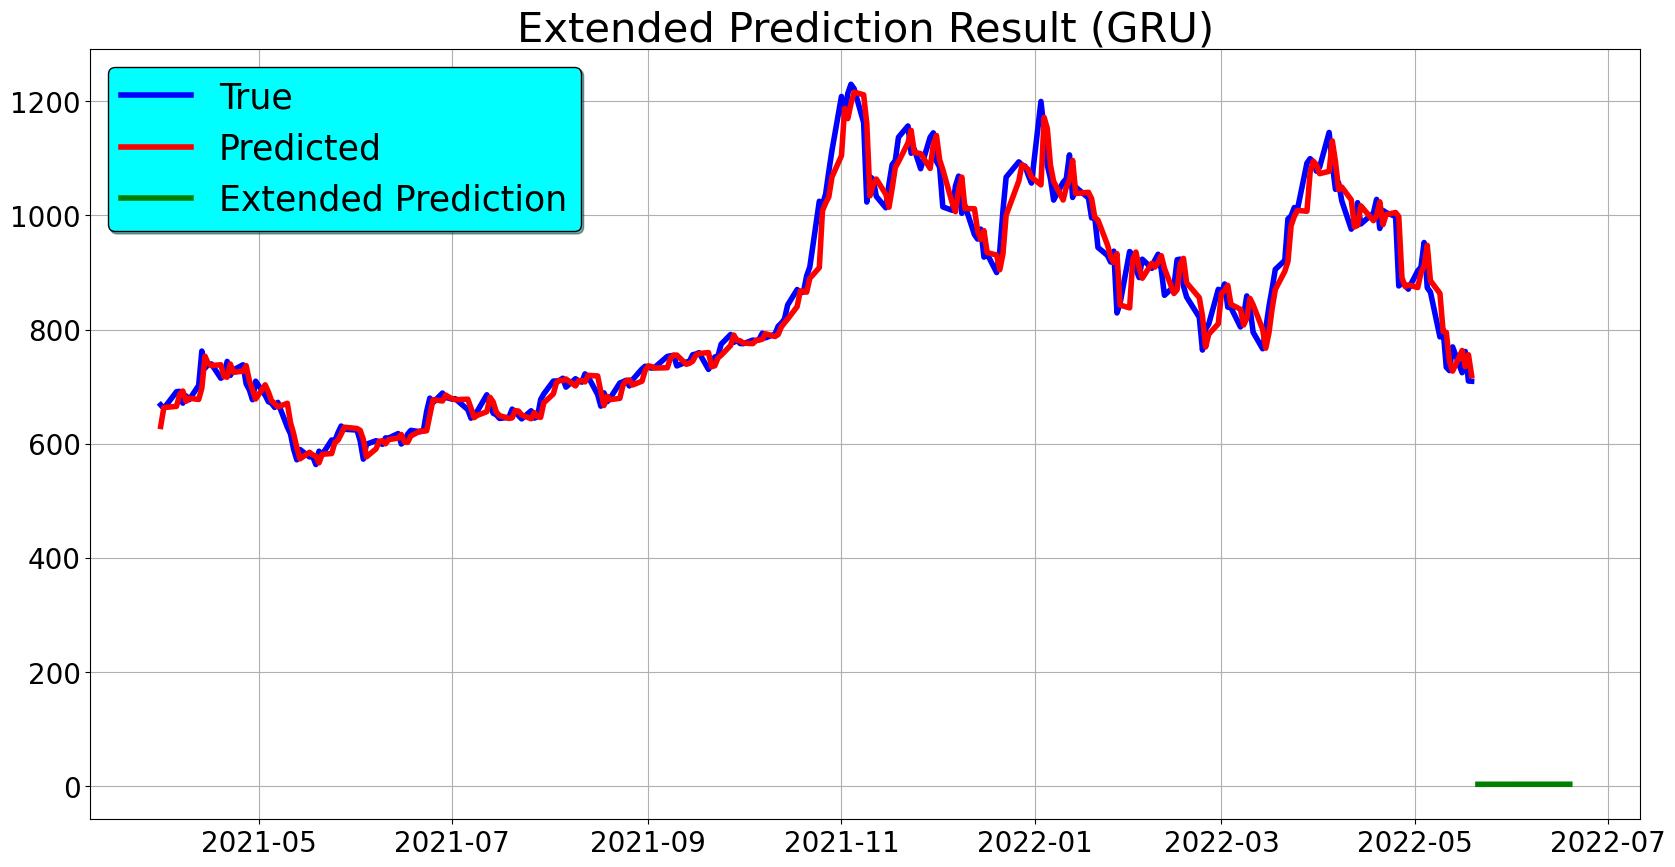

In [475]:
# Define the number of days to predict
prediction_days = 30

# Initialize the input sequence with the last window of the test data
input_sequence = X_test[-1]

# Create an array to store the predicted values
predicted_values = []

# Predict for the specified number of days
for _ in range(prediction_days):
    # Reshape the input sequence to match the model's input shape
    input_sequence = input_sequence.reshape(1, window_size, 1)
    
    # Make a prediction for the next day
    next_day_prediction = model_1.predict(input_sequence)
    
    # Append the prediction to the list of predicted values
    predicted_values.append(next_day_prediction[0][0])
    
    # Update the input sequence by removing the first element and adding the prediction
    input_sequence = np.roll(input_sequence, shift=-1)
    input_sequence[-1] = next_day_prediction[0]

# Convert the predicted values to a numpy array
predicted_values = np.array(predicted_values)

# Create an index for the predicted values
predicted_index = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=prediction_days, freq='D')

# Plot the predicted values
plt.figure(figsize=(20, 10))
plt.grid(b=True, which='major', axis='both')
plt.title('Extended Prediction Result (GRU)', fontsize=30)
plt.plot(y_test_index, y_test, linewidth=4, label='True', color='blue')
plt.plot(y_test_index, test_predict_1, linewidth=4, color='red', label='Predicted')
plt.plot(predicted_index, predicted_values, linewidth=4, color='green', label='Extended Prediction')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=25, shadow=True, facecolor='cyan', edgecolor='k')
plt.show()


In [482]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load your time series data (e.g., 'Close' prices)
data = pd.read_csv('TSLA.CSV')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Feature engineering: Create lag features
lag_features = ['Close']
num_lags = 5  # Choose the number of lag observations to include as features

for i in range(1, num_lags + 1):
    for feature in lag_features:
        data[f'{feature}_lag_{i}'] = data[feature].shift(i)



data


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5
Date,,,,,,,,,,,,
2019-05-21,39.551998,41.480000,39.208000,41.015999,90019500,0,0.0,NaN,NaN,NaN,NaN,NaN
2019-05-22,39.820000,40.787998,38.355999,38.546001,93426000,0,0.0,41.015999,NaN,NaN,NaN,NaN
2019-05-23,38.868000,39.894001,37.243999,39.098000,132735500,0,0.0,38.546001,41.015999,NaN,NaN,NaN
2019-05-24,39.966000,39.995998,37.750000,38.125999,70683000,0,0.0,39.098000,38.546001,41.015999,NaN,NaN
2019-05-28,38.240002,39.000000,37.570000,37.740002,51564500,0,0.0,38.125999,39.098000,38.546001,41.015999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-16,767.159973,769.760010,719.090027,724.369995,28699500,0,0.0,769.590027,728.000000,734.000000,800.039978,787.109985
2022-05-17,747.359985,764.479980,728.849976,761.609985,26745400,0,0.0,724.369995,769.590027,728.000000,734.000000,800.039978
2022-05-18,744.520020,760.500000,700.809998,709.809998,29270600,0,0.0,761.609985,724.369995,769.590027,728.000000,734.000000


In [483]:
# Drop rows with missing values (due to lag)
data.dropna(inplace=True)

# Split the data into training and testing sets
train_size = int(0.8 * len(data))
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# Separate features (X) and target (y)
X_train, y_train = train_data.drop('Close', axis=1), train_data['Close']
X_test, y_test = test_data.drop('Close', axis=1), test_data['Close']




In [486]:
X_train

,Open,High,Low,Volume,Dividends,Stock Splits,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5
Date,,,,,,,,,,,
2019-05-29,37.419998,38.478001,37.007999,59843000,0,0.0,37.740002,38.125999,39.098000,38.546001,41.015999
2019-05-30,37.750000,38.452000,37.403999,39632500,0,0.0,37.972000,37.740002,38.125999,39.098000,38.546001
2019-05-31,37.020000,37.984001,36.820000,52033500,0,0.0,37.644001,37.972000,37.740002,38.125999,39.098000
2019-06-03,37.102001,37.335999,35.397999,65322000,0,0.0,37.032001,37.644001,37.972000,37.740002,38.125999
2019-06-04,36.220001,38.796001,35.922001,69037500,0,0.0,35.793999,37.032001,37.644001,37.972000,37.740002
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-08,796.210022,796.380005,780.909973,16738600,0,0.0,793.609985,782.750000,780.590027,781.530029,775.219971
2021-10-11,787.650024,801.239990,785.500000,14200300,0,0.0,785.489990,793.609985,782.750000,780.590027,781.530029
2021-10-12,800.929993,812.320007,796.570007,22020000,0,0.0,791.940002,785.489990,793.609985,782.750000,780.590027


In [ ]:
# Initialize and fit a scaler (optional, but recommended)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a simple feedforward neural network (MLP)
model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE) for the predictions
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual Close Prices')
plt.plot(test_data.index, y_pred, label='Predicted Close Prices', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Prices')
plt.legend()
plt.grid()
plt.show()